In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
import segmentation_models_pytorch as smp
from joblib import dump, load


# plt.rcParams['figure.figsize'] = (5, 5)
# plt.rcParams['figure.facecolor'] = 'gray'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
DATASET_FOLDER = "./Dataset_modified/"

In [3]:
class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic_light',
               'traffic_sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus',
               'train', 'motorcycle', 'bicycle']
colors = np.array([
    [0,   0,   0],
    [128, 64, 128],
    [244, 35, 232],
    [70, 70, 70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170, 30],
    [220, 220, 0],
    [107, 142, 35],
    [152, 251, 152],
    [70, 130, 180],
    [220, 20, 60],
    [255, 0, 0],
    [0, 0, 142],
    [0, 0, 70],
    [0, 60, 100],
    [0, 80, 100],
    [0, 0, 230],
    [119, 11, 32],
])

In [4]:
def split_image(img: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    pic = img[:, :256, :]
    mask = img[:, 256:, :]
    return pic, mask


def colorize(codebook, predicted):
    ids = predicted.reshape(20, -1).argmax(axis=0).reshape(1, 256, 256)
    return codebook[ids].reshape(predicted.shape[-1], predicted.shape[-2], 3)


def visualize(codebook, p, m, predicted, save=False):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 3, 1)
    ax.set_axis_off()
    ax.imshow(p.moveaxis(0, -1))
    ax = fig.add_subplot(1, 3, 2)
    ax.set_axis_off()
    ax.imshow(m.moveaxis(0, -1))
    ax = fig.add_subplot(1, 3, 3)
    ax.set_axis_off()
    ax.imshow(colorize(codebook, predicted))
    fig.savefig("out.png")


class CityscapesDataset(Dataset):
    def __init__(self, labels: np.ndarray, colors: np.ndarray,
                 root_dir: str = "./Dataset_modified/", split: str = "Train"):
        assert len(labels) == len(colors)
        self.labels = labels
        self.colors = colors
        self.root_dir = root_dir
        self.split = split
        self.pics = np.load(os.path.join(root_dir, split, "pics.npy"))
        self.masks = np.load(os.path.join(
            root_dir, split, "masks.npy"))
        self.labels = np.load(os.path.join(
            root_dir, split, "labels.npy"))

    def __len__(self):
        return len(self.pics)

    def __getitem__(self, idx):
        return torch.as_tensor(np.moveaxis(self.pics[idx], -1, 0), dtype=torch.float32)/255.0, \
            torch.as_tensor(np.moveaxis(self.masks[idx], -1, 0), dtype=torch.float32)/255.0, \
            torch.as_tensor(np.moveaxis(
                self.labels[idx], -1, 0), dtype=torch.long)


class LearningModel(pl.LightningModule):
    def __init__(self, ):
        super().__init__()
        self.unet = smp.Unet(classes=len(colors))
        self.criterion = smp.losses.JaccardLoss(mode="multiclass", classes=list(range(1,len(colors))))
        self.metrics = torchmetrics.JaccardIndex(num_classes=len(colors))
    
    def forward(self, x):
        segments = self.unet(x)
        return segments

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, _, y = train_batch
        y_hat = self.unet(x)
        loss = self.criterion(y_hat, y.long())
        iou = self.metrics(y_hat, y)
        self.log('train_loss', loss,on_step=False, on_epoch=True,prog_bar=True)
        self.log('train_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
        return loss

    # def validation_step(self, val_batch, batch_idx):
    #     x, _, y = val_batch
    #     y_hat = self.unet(x)
    #     loss = self.criterion(y_hat, y.long())
    #     iou = self.metrics(y_hat, y)
    #     self.log('val_loss', loss)
    #     self.log('val_iou', iou,on_step=False, on_epoch=True,prog_bar=False)
    #     return loss


In [5]:
train_ds = CityscapesDataset(class_names, colors, DATASET_FOLDER, "Train")
train_dl = DataLoader(train_ds, batch_size=25, shuffle=True,
                      generator=torch.random.manual_seed(1), num_workers=os.cpu_count())

test_ds = CityscapesDataset(class_names, colors, DATASET_FOLDER, "Test")
test_dl = DataLoader(test_ds, batch_size=10, num_workers=os.cpu_count())


In [24]:
# model = LearningModel()
# checkpoint_callback = ModelCheckpoint(
#     save_top_k=10,
#     monitor="train_loss",
#     mode="min",
#     filename="cityscapes-unet-{epoch:02d}-{train_loss:.2f}",
#     every_n_epochs=20
# )
# trainer = pl.Trainer(max_epochs=200, accelerator="gpu", gpus=1, log_every_n_steps=10,
#                      callbacks=[checkpoint_callback])
# trainer.fit(model, train_dl, test_dl)

# model = LearningModel.load_from_checkpoint("./unet-200.ckpt")
# model = LearningModel.load_from_checkpoint("./lightning_logs/version_4/checkpoints/cityscapes-unet-epoch=199-train_loss=0.24.ckpt")
# model = LearningModel.load_from_checkpoint("./lightning_logs/version_6/checkpoints/cityscapes-unet-epoch=139-train_loss=0.37.ckpt")
model = LearningModel.load_from_checkpoint("./lightning_logs/version_4/checkpoints/cityscapes-unet-epoch=199-train_loss=0.24.ckpt")


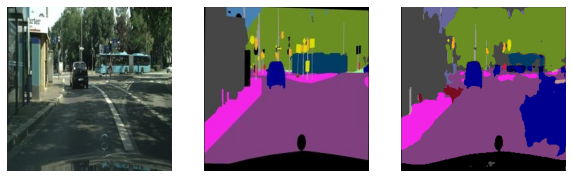

In [28]:
idx = 9
p,m,l = test_ds[idx]
y_hat = model(p.reshape((1,p.shape[0],p.shape[1],p.shape[2])))

visualize(colors, p, m, y_hat, save=False)